<h1>The Battle of Neighborhoods</h1>

Capstone project notebook for Data Science Professional Certificate by IBM via Coursera.

<h2>Task</h2>

In this assignment, you will be required to explore, segment, and cluster the neighborhoods in the city of Toronto. However, unlike New York, the neighborhood data is not readily available on the internet. What is interesting about the field of data science is that each project can be challenging in its unique way, so you need to learn to be agile and refine the skill to learn new libraries and tools quickly depending on the project.

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. You will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the New York dataset.

Once the data is in a structured format, you can replicate the analysis that we did to the New York City dataset to explore and cluster the neighborhoods in the city of Toronto.

Your submission will be a link to your Jupyter Notebook on your Github repository.

<h2>Importing and preprocessing data</h2>
<h3>Retrieving Neighborhood List</h3>

We first import the necessary libraries requests and pandas for downloading the table with data from wikipedia. As the homepage structure is quite simple, we can use pandas to extract the table with postal codes of Canada. Numpy is going to be used for treating NaN values and might be useful for handling arrays later.

In [1]:
# Import libraries
import requests
import pandas as pd
import numpy as np

# Request homepage data
page = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
# Read tables of the homepage
tables = pd.read_html(page.text)
# Extract the table of interest. We do not want unassigned Boroughs as they are crucial for our analysis.
table = tables[0].dropna(subset=["Borough"], axis=0)

Let us have a quick look at the table.

In [2]:
table.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


It is easily visible that the dataset did not fill unassigned Boroughs with NaN but rather wth Not assigned. We need to replace this with NaN to drop the unassigned borough rows.

In [3]:
# Replace "Not assigned with NaN
table.replace(to_replace="Not assigned",value=np.nan, inplace=True)

# Attempt dropping the unassigned boroughs again
table.dropna(subset=["Borough"], axis=0, inplace=True)

#Rename "Postalcode" with "Postal Code"
table.rename({"Postalcode":"Postal Code", "Borough":"Borough", "Neighborhood":"Neighborhood"}, axis=1, inplace=True)

# Have a look at the result
table.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


This looks quite good. Let us have a closer look with the describe method.

In [4]:
table.describe()

,Postal Code,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M4G,North York,Downsview
freq,1,24,4


The table structure looks suitable. The describe method informs us, that there are 10 boroughs and 98 neighborhoods. One of the neighborhoods seems to appear four times which seems quite curious. Our current understanding of the data hints at neighborhoods being the smallest unit in the data, thus, one might expect the same number of neighborhoods as we find in the postal codes. Let us look into this before we proceed.

In [5]:
# Check if unassigned neighboorhoods are left in the dataframe
table[table["Neighborhood"]==np.nan]

,Postal Code,Borough,Neighborhood


In [6]:
# Check which neighborhoods appear more than once.
table["Neighborhood"].value_counts()

Downsview                                       4
Don Mills                                       2
New Toronto, Mimico South, Humber Bay Shores    1
Woburn                                          1
North Park, Maple Leaf Park, Upwood Park        1
                                               ..
Willowdale, Willowdale West                     1
Dufferin, Dovercourt Village                    1
Stn A PO Boxes                                  1
The Annex, North Midtown, Yorkville             1
Christie                                        1
Name: Neighborhood, Length: 99, dtype: int64

In [7]:
# Look at the neighborhood Downsview.
table[table["Neighborhood"]=="Downsview"]

,Postal Code,Borough,Neighborhood
65,M3K,North York,Downsview
74,M3L,North York,Downsview
83,M3M,North York,Downsview
92,M3N,North York,Downsview


The data looks fine so far. Interestingly there seem to be some cases of larger neighborhoods that have only one neighborhood name defined for neighboring postal codes. There do not seem any undefine neighborhoods left in the dataset. We can proceed with this data.

In [8]:
table.shape

(103, 3)

<h3>Geocode retrieval of coordinates</h3>

With the dataframe at hand, we will now require the coordinates of our neighborhoods for querying details about them from Foursquare later on. We use the geocoder library for this. Python lists for the latitudes and longitudes are populated with a for loop over the rows of our data. They are efficient data storage structures for later appending them to our dataframe.

The Google API needs credit card info now which I am not willing to give at this stage, considering I am not planning to use geocoding in my later projects. We will attempt to retrieve data from OpenStreetMap.

**ATTENTION:** Running below code might take a few minutes.

In [9]:
import geocoder # Import geocoder
import time # Import timer
# Initialize lists for storing the retrieved location data.
latitudes = []
longitudes = []

start = time.time() #Timer for the process

# Loop over all rows for retrieving the values one by one.
for index in range(table.shape[0]):
    # Initialize your variable to None
    lat_lng_coords = None
    
    # Initialize the row's postal code
    postal_code = table.iloc[index,:]["Postal Code"]
    
    # Initialize i to 0
    i=0

    # Loop until you get the coordinates. This can take a while.
    # Loop limited to 5 attempts for each postal code.
    
    while i<5 and lat_lng_coords==None:
        g = geocoder.osm('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
        try:
            latitude = lat_lng_coords[0]
            longitude = lat_lng_coords[1]
        except:
            latitude = np.nan
            longitude = np.nan
        finally:
            i+=1
            
    latitudes.append(latitude)
    longitudes.append(longitude)

end = time.time()
print("Time elapsed: " + str(round((end - start),2)) + " s")


Time elapsed: 209.13 s


This takes quite a while. Let us have a look at the results.

In [10]:
latitudes

[43.6534817,
 nan,
 nan,
 nan,
 43.6534817,
 nan,
 43.6534817,
 nan,
 nan,
 nan,
 nan,
 43.64074125,
 43.6534817,
 43.7328216,
 nan,
 nan,
 nan,
 43.64410993066079,
 nan,
 nan,
 43.6421064,
 nan,
 43.76571676956549,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 43.64989555,
 nan,
 nan,
 43.7797719,
 nan,
 nan,
 43.63925859999999,
 43.6522219,
 nan,
 nan,
 nan,
 nan,
 nan,
 43.63709690913502,
 nan,
 nan,
 nan,
 43.6727601,
 nan,
 nan,
 nan,
 nan,
 43.7859621,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 43.7792385670669,
 nan,
 nan,
 nan,
 43.67556585,
 nan,
 nan,
 nan,
 nan,
 nan,
 43.662172749999996,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 43.69516618990701,
 nan,
 nan,
 nan,
 43.6492308,
 nan,
 nan,
 nan,
 nan,
 nan,
 43.6456336,
 nan,
 nan,
 43.81545466594209,
 nan,
 nan,
 nan,
 nan,
 nan,
 43.6680266,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [11]:
print("Latitudes contains "+ str(len(latitudes)) +" items, " + str(latitudes.count(np.nan)) + " of which are NaN."
      " Longitudes contains "+ str(len(longitudes)) +" items, "  + str(longitudes.count(np.nan)) + " of which are NaN.")

Latitudes contains 103 items, 79 of which are NaN. Longitudes contains 103 items, 79 of which are NaN.


OpenStreetMap seems to only have very limited functionality in the desired region in Toronto. We will have to use the pre-compiled csv with geocodes of the postal codes. Let us first import the data.

In [12]:
lat_lng_table = pd.read_csv("https://cocl.us/Geospatial_data")
print(lat_lng_table.shape)
lat_lng_table.head()

(103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now we will set the postal codes as index to prepare both dataframes for an inner join operation.

In [13]:
lat_lng_table.set_index("Postal Code", inplace=True)
print(lat_lng_table.shape)
lat_lng_table.head()

(103, 2)


,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [14]:
table.set_index("Postal Code", inplace=True)
table.head()

,Borough,Neighborhood
Postal Code,,
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights"
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Perform an inner join to concatenate both labels along the postal code column.

In [15]:
table_cat = pd.concat([table, lat_lng_table], axis=1, join='inner', sort=False)
print(table_cat.shape)
table_cat

(103, 4)


,Borough,Neighborhood,Latitude,Longitude
Postal Code,,,,
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...
M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558


Finally, we reset the index and rename the intermediate index "Postal Code". In some iterations of the wikipedia list, there was no space present here.

In [16]:
table_cat.reset_index(inplace=True)

table_cat.rename({"index":"Postal Code", "Borough":"Borough", "Neighborhood": "Neighborhood",
                  "Latitude":"Latitude", "Longitude":"Longitude"}, inplace=True
                )

print(table_cat.shape)
table_cat

(103, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


Just out of interest, let us have a look if the retrieved data from the OpenStreetMap is equivalent to the data in this table. We round the coordinate floats to 2 digits and check for equality.

In [17]:
print("Latitudes that are similar in the OSM data to the data from the pre-compiled .csv:",
      (round(table_cat["Latitude"],2)==round(pd.DataFrame(latitudes), 2)).sum().sum())
print("Longitudes that are similar in the OSM data to the data from the pre-compiled .csv:",
      (round(table_cat["Longitude"],2)==round(pd.DataFrame(longitudes), 2)).sum().sum())

Latitudes that are similar in the OSM data to the data from the pre-compiled .csv: 0
Longitudes that are similar in the OSM data to the data from the pre-compiled .csv: 1


Only a single longitude was roughly equivalent to the data from the csv file. This is not very promising for the OpenStreetMap API, so we will not dedicate further efforts towards making OSM work and stick to the pre-compiled csv data.

<h3>Importing Foursquare Data</h3>

We will now use the data to access Foursquare and do some initial clustering to achieve an understanding of the data before we go into the capstone research.

In [18]:
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Libraries imported.')

Libraries imported.


In [19]:
import os

CLIENT_ID = ""
CLIENT_SECRET = ""

CLIENT_ID = os.getenv('FOURSQUARE_CLIENT_ID')
CLIENT_SECRET = os.environ.get('FOURSQUARE_CLIENT_SECRET')

VERSION = '20200605'
LIMIT = 200


if len(CLIENT_ID)>0:
    print('Client ID read succesfully!')
else:
    print('There is a problem with the client ID...')

if len(CLIENT_SECRET)>0 :
    print('Client secret read succesfully!')
else:
    print('There is a problem with the client secret...')

Client ID read succesfully!
Client secret read succesfully!


In [20]:
search_query = ''
radius = 500
print(search_query + ' .... OK!')
table_test = []
venues_list = []

for i in range(len(table_cat["Latitude"])):
    
    latitude=table_cat["Latitude"][i]
    longitude=table_cat["Longitude"][i]
    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    url
    results = requests.get(url).json()
    
    venues_list.append(pd.json_normalize(results['response']['groups'][0]['items']))
    # assign relevant part of JSON to venues
    #venues = results['response']['venues']

    # tranform venues into a dataframe
    #venues_list.append(pd.json_normalize(venues))
    #venues_list.head()

 .... OK!


We have now stored the dataframes of venues at each of the requested neighborhoods in a list iterating over the neighborhoods. Let us have a look at the first entry.

In [21]:
print('The list contains {} items.'
      .format(len(venues_list)),
      'We expect {} items.'.format(len(table_cat)),
     )
if len(table_cat)==len(venues_list):
    print('Perfect!')
else:
    print('ERROR, the list does not have the expected number of entries.')
    
print('\nHere is the head of the first entry:')

venues_list[0].head()

The list contains 103 items. We expect 103 items.
Perfect!

Here is the head of the first entry:


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.postalCode
0,e-0-4e8d9dcdd5fbbbb6b3003c7b-0,0,"[{'summary': 'This spot is popular', 'type': '...",4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,Toronto,43.751976,-79.332140,"[{'label': 'display', 'lat': 43.75197604605557...",245,CA,Toronto,ON,Canada,"[Toronto, Toronto ON, Canada]","[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",0,[],NaN
1,e-0-4cb11e2075ebb60cd1c4caad-1,0,"[{'summary': 'This spot is popular', 'type': '...",4cb11e2075ebb60cd1c4caad,Variety Store,29 Valley Woods Road,43.751974,-79.333114,"[{'label': 'display', 'lat': 43.75197441585782...",312,CA,Toronto,ON,Canada,"[29 Valley Woods Road, Toronto ON, Canada]","[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",0,[],NaN
2,e-0-5921cc82e96d0c63d980640c-2,0,"[{'summary': 'This spot is popular', 'type': '...",5921cc82e96d0c63d980640c,Corrosion Service Company Limited,9-280 Hillmount Rd.,43.752432,-79.334661,"[{'label': 'display', 'lat': 43.75243208667859...",412,CA,Markham,ON,Canada,"[9-280 Hillmount Rd., Markham ON L6C 3A1, Canada]","[{'id': '5454144b498ec1f095bff2f2', 'name': 'C...",0,[],L6C 3A1


Let us look at an example of how to navigate this hyper-nested structure containing dataframes in lists. Some of the dataframe items are still in json format and can be treated as nests of dictionaries in lists. Below example retrieves a single category shortName.

We will later want to loop through each of the three indices:

<ol>
<li>The first index chooses one of our neighborhoods.</li>
<li>The second index chooses one of the venues at the location.</li>
<li>The third index chooses the category of the venue in case it has several.</li>
</ol>

In [22]:
#results = requests.get(url).json() []['venue']['categories'][0]['name']

venues = venues_list[0]['venue.categories'][0][0]['shortName']
venues

'Park'

<h3>Foursquare Data Wrangling</h3>

Let us clean the data. It will be much more convenient to use it from a dataframe without further nesting. We first drop all columns with irrelevant data, give the rows better labels, and then extract the category name.

In [23]:
def filter_columns(dataframe):

    filtered_columns = []
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location')] + ['venue.id']
    droplist = ('cc', 'labeledLatLngs', 'state', 'formattedAddress', 'crossStreet', 'neighborhood', 'country')
    # drop redundant location descriptors

    for col in dataframe.columns:
        
        if col.endswith(droplist):
            filtered_columns.remove(col)
            
    # define the filtered dataframe
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name'] # We only employ the main category of venues that have more than one

    # filter the category for each row
    dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

    #print(dataframe_filtered.shape)
    #dataframe_filtered.head()
    return dataframe_filtered

venues_filtered=[]

for i in range(len(venues_list)):
    try:
        venues_filtered.append(filter_columns(venues_list[i]))
    except:
        venues_filtered.append(venues_filtered[i-1].iloc[0:0])

    #for index in range(len(venues_list)):
#    venues_list_filtered[index] = filter_columns(venues_list[index])

venues_filtered now is a much cleaner list:

In [24]:
venues_filtered

[                                name                  categories  \
 0                    Brookbanks Park                        Park   
 1                      Variety Store           Food & Drink Shop   
 2  Corrosion Service Company Limited  Construction & Landscaping   
 
                 address        lat        lng  distance     city postalCode  \
 0               Toronto  43.751976 -79.332140       245  Toronto        NaN   
 1  29 Valley Woods Road  43.751974 -79.333114       312  Toronto        NaN   
 2   9-280 Hillmount Rd.  43.752432 -79.334661       412  Markham    L6C 3A1   
 
                          id  
 0  4e8d9dcdd5fbbbb6b3003c7b  
 1  4cb11e2075ebb60cd1c4caad  
 2  5921cc82e96d0c63d980640c  ,
                                         name             categories  \
 0                     Victoria Village Arena           Hockey Arena   
 1                                  Portugril  Portuguese Restaurant   
 2                                Tim Hortons            Co

Let us look at the contained dataframe:

In [25]:
venues_filtered[0]

,name,categories,address,lat,lng,distance,city,postalCode,id
0,Brookbanks Park,Park,Toronto,43.751976,-79.332140,245,Toronto,NaN,4e8d9dcdd5fbbbb6b3003c7b
1,Variety Store,Food & Drink Shop,29 Valley Woods Road,43.751974,-79.333114,312,Toronto,NaN,4cb11e2075ebb60cd1c4caad
2,Corrosion Service Company Limited,Construction & Landscaping,9-280 Hillmount Rd.,43.752432,-79.334661,412,Markham,L6C 3A1,5921cc82e96d0c63d980640c


An item can now be easily retrieved with two indices rather than three, because we ignored that Foursquare allows venues to have several categories.

In [26]:
venues_filtered[0]['categories']

0                          Park
1             Food & Drink Shop
2    Construction & Landscaping
Name: categories, dtype: object

What we will want to do now is one hot encoding of the categories. As we, however, have a list containing dataframes for each element of the final dataframe that sorts our venues by location, we can do the following:
    
<ol>
<li>One hot encode the categories in each neighborhood's dataframe.</li>
<li>Extract a set containing all category names to insert new rows in our location dataframe.</li>
<li>Add the sums of the categories of venues at each location to the location dataframe.</li>
</ol>

Let us check how many locations we were able to retrieve:

In [27]:
n=0
for i in range(len(venues_list)):
    for j in range(len(venues_list[i])):
        n += 1
print(n)

2131


<h3>Feature construction</h3>

For constructing our features, we will first want to one-hot encode the venue categories so that we can use the types of venue in order to group neighborhoods later. We will need a set containing all categories.

In [28]:
categories = set()
for i in range(len(venues_filtered)):
    for j in range(len(venues_filtered[i])):
        venues_filtered[i]['categories'] = pd.Categorical(venues_filtered[i]['categories'])
        categories.add(venues_filtered[i]['categories'][j])

categories

{'Accessories Store',
 'Afghan Restaurant',
 'Airport',
 'Airport Food Court',
 'Airport Gate',
 'Airport Lounge',
 'Airport Service',
 'Airport Terminal',
 'American Restaurant',
 'Antique Shop',
 'Aquarium',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Garage',
 'Auto Workshop',
 'BBQ Joint',
 'Baby Store',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Basketball Stadium',
 'Beach',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Store',
 'Belgian Restaurant',
 'Bike Rental / Bike Share',
 'Bike Shop',
 'Bistro',
 'Board Shop',
 'Boat or Ferry',
 'Bookstore',
 'Boutique',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Bubble Tea Shop',
 'Building',
 'Burger Joint',
 'Burrito Place',
 'Bus Line',
 'Bus Station',
 'Business Service',
 'Butcher',
 'Cafeteria',
 'Café',
 'Cajun / Creole Restaurant',
 'Camera Store',
 'Candy Store',
 'Caribbean Restau

A venue category is called Neighborhood. This seems not helpful and clashes with our own neighborhood column later. Let us drop this.

In [29]:
categories.remove('Neighborhood')

Let us now calculate haversine distances between the coordinates of our venues as a measure of how centralized the venues in our neighborhood are. This gives us a measure of their accessibility for our later investigations.

In [30]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians


for i in range(len(venues_filtered)):
    venues_filtered[i] = venues_filtered[i].reindex(columns = venues_filtered[i].columns.tolist() + ['Distance to others'])
    for j in range(len(venues_filtered[i])):
        loc1 = [venues_filtered[i]['lat'][j],venues_filtered[i]['lng'][j]]
        distance_list=[]
        for k in range(len(venues_filtered[i])):
                loc2 = [venues_filtered[i]['lat'][k],venues_filtered[i]['lng'][k]]
                #Calculate Havesine distance and multiply by earth radius to get it in meters.
                loc1_in_radians = [radians(_) for _ in loc1]
                loc2_in_radians = [radians(_) for _ in loc2]
                result = int(haversine_distances([loc1_in_radians, loc2_in_radians])[0][1]*6371000)
                distance_list.append(result)
                #Remove zero as the distance to the own venue is not interesting.
                try:
                    distance_list.remove(0)
                except:
                    None
        if distance_list != np.nan:
            try:
                venues_filtered[i].loc[j, 'Distance to others'] = np.mean(distance_list)
            except:
                venues_filtered[i].loc[j, 'Distance to others'] = np.nan
        else:
            None

C:\Users\Admin\Anaconda3\envs\jupyter-lab1\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Admin\Anaconda3\envs\jupyter-lab1\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
#Initialize a dictionary of lists of the categories to populate with sums/means to add to our main list of neighborhood data.

d={}
d['Postal Code']=table_cat.index
d['Distance to others']=[]
d['Number of venues']=[]


for i in range(len(venues_filtered)):
    #Add the total number of venues to our dictionary to give it weight for our later models
    d['Number of venues'].append(len(venues_filtered[i]))
    #Incorporate the distance means into our dictionary.
    try:
        d['Distance to others'].append(int(np.mean(venues_filtered[i].loc[:, 'Distance to others'])))
    except:
        d['Distance to others'].append(np.nan)        

    
for category in categories:
    d[category]=[]


#First get the dummies for one-hot encoding the categories of our venues at a single neighborhood.
       
for i in range(len(venues_filtered)):
    try:
        venues_filtered[i]['categories'] = pd.Categorical(venues_filtered[i]['categories'])
        dfDummies = pd.get_dummies(venues_filtered[i]['categories'], prefix = 'category')
        
    except:
        dfDummies = None
    
    venues_filtered[i] = pd.concat([venues_filtered[i], dfDummies], axis=1)

#Now we will append the dictionary with the number of venues of each category to start creating
#our "overview" list with all neighborhoods included.
     
    for category in categories:
        try:
            d[category].append(sum(venues_filtered[i]['category_'+str(category)]))
        except:
            d[category].append(0)

#We will want to construct further features for analyzing our neighborhoods and their venues.


In [32]:
table_cat = pd.concat([table_cat, pd.DataFrame(d).set_index(keys='Postal Code')], axis=1)
table_cat.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance to others,Number of venues,Distribution Center,General Travel,Cajun / Creole Restaurant,...,Train Station,Pool,Roof Deck,Massage Studio,Salad Place,Hotel Bar,Middle Eastern Restaurant,Bistro,Garden,Tea Room
0,M3A,North York,Parkwoods,43.753259,-79.329656,140.0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,162.0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,473.0,44,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,344.0,15,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,521.0,34,1,0,0,...,0,0,0,0,0,0,0,0,0,0


We now have a nice dataframe for describing our neighborhood. However, we see that the Foursquare categories might be a bit too detailed to properly compare the neighborhoods, as many categories will only occur once or twice in our dataset. We know from earlier that we have gathered 1338 locations.

In [33]:
print('We have found '+
      str(table_cat.loc[:,'Number of venues'].sum())+
      ' locations.\n'+
      'They are spread over '+
      str(len(categories))+
      ' categories.\n'+
      'This means that on average there are '+
      str(round(table_cat.loc[:,'Number of venues'].sum()/len(categories),1))+
      ' venues in a category.')

We have found 2131 locations.
They are spread over 272 categories.
This means that on average there are 7.8 venues in a category.


In [34]:
#table_cat.describe()
#table_cat.Neighborhood

12 locations that do not have a single venue recorded have missing values for the mean distance to others. The best way to deal with that is to insert the mean of all others in these spots to not infer distortion of the analysis results.

In [35]:
table_cat.iloc[:,5].fillna(np.mean(table_cat.iloc[:,5]), inplace=True)
    
(table_cat==np.nan).sum().sum()

0

In [36]:
table_cat.iloc[:,5]

0      140.000000
1      162.000000
2      473.000000
3      344.000000
4      521.000000
          ...    
98     612.000000
99     421.000000
100    297.000000
101    332.129032
102    208.000000
Name: Distance to others, Length: 103, dtype: float64

The mean was succesfully inserted the mean distance in rows with 1 or 0 venues.

<h3>Preliminary Data Analysis</h3>

Let us now have a look into the dataset that we created. Let us first check a boxplot of the number of venues and their density (i.e. distance to each other).

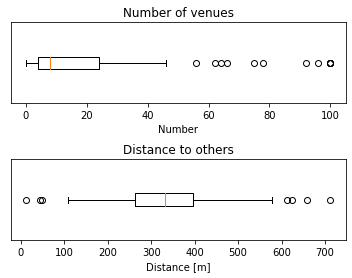

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2)
plt.subplots_adjust(hspace = 0.7)

ax[0].boxplot(table_cat['Number of venues'], vert=False)
ax[0].set_title('Number of venues')
ax[0].set_xlabel('Number')

ax[1].boxplot(table_cat['Distance to others'][~np.isnan(table_cat['Distance to others'])], vert=False)
ax[1].set_title('Distance to others')
ax[1].set_xlabel('Distance [m]')

for ax in fig.get_axes():
    ax.set_yticks([])

The vast majority of Neighborhoods has below 43 venues (maximum: median(8 venues) + 1.5 * 3rd quartile(23)), with the interquartile range (IQR) spanning 4 to 23 venues. With only a few outliers we can assume that most neighborhoods are captured representatively.

All data points apart from 7 are also captured in the IQR for the mean distance of venues to other venues. Let us have a closer look at this feature.

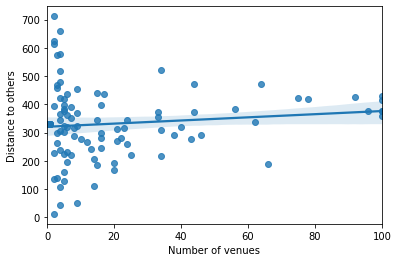

In [38]:
sns.regplot(table_cat['Number of venues'], table_cat['Distance to others'])

In [39]:
def PlotPolly(model, independent_variable, dependent_variabble, Name):
    x_new = np.linspace(0, 100, 100)
    y_new = model(x_new)
    fig = plt.figure(figsize=(7,5))
    plt.plot(independent_variable, dependent_variabble, '.')
    plt.plot(x_new, y_new, '-')
    plt.title('Polynomial Fit (degree=3)')
    ax = plt.gca()
   # ax.patch.set_facecolor((0.898, 0.898, 0.898))
    plt.gcf()
    #fig.patch.set_facecolor((0.898, 0.898, 0.898))
    plt.ylabel("Distance to others")
    plt.xlabel("Number of venues")
#    plt.yticks(np.linspace(-10000,50000,7))
#    plt.xticks(np.linspace(15,55,9))
    
#    ax.spines['bottom'].set_color('white')
#    ax.spines['top'].set_color('white') 
#    ax.spines['right'].set_color('white')
#    ax.spines['left'].set_color('white')
#    ax.tick_params(axis='x', colors='white')
#    ax.tick_params(axis='y', colors='white')
#    plt.ylim(0,50000)
#    plt.xlim(15,55)
#    fig.savefig('polyfit.png', transparent=True, dpi=300)
    plt.show()
    plt.close()

In [40]:
x = table_cat['Number of venues']
y = table_cat['Distance to others']

In [41]:
# Here we use a polynomial of the 3rd order (cubic) 
f = np.polyfit(x, y, 3)
p = np.poly1d(f)
print(p)

           3          2
-0.001181 x + 0.1883 x - 6.77 x + 360


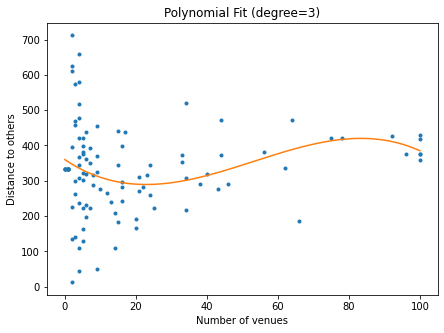

In [42]:
PlotPolly(p, x, y, 'Distance to others')


Interestingly, an increasing amount of registered venues is not clearly correlated with decreasing distance between the venues. Neighborhoods with low amounts of recorded venues sometimes have them very close to each other, sometimes far from each other. With increasing amount of recorded venues, mainly the distribution becomes more narrow rather than showing a decreasing mean distance.

They rather seem to be closely clustered, which also makes sense. This indicates that Torronto is heavy in "High Street" and "Shopping Mall" arrangements where even with lower venue amounts they gather quite closely.

<h2>Clustering Torronto Neighborhoods</h2>

<h3>First Clustering</h3>

Let us now cluster our neighborhoods with a few different algorithms and see how it turns out.

In [43]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

X = StandardScaler().fit_transform(table_cat.iloc[:,5:])
methods=[]
method='K-Means (k-means++)'

kmeans = KMeans(n_clusters=5, random_state=0, algorithm='auto', init='k-means++').fit(X)
#kmeans.labels_==2
#kmeans.cluster_centers_

for label in set(kmeans.labels_):
    label_list =[]
    for index, g in enumerate(kmeans.labels_):
        if g==label:
            label_list.append(index)
    print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))
    
table_cat_clusters = pd.concat([table_cat, pd.DataFrame(kmeans.labels_).rename(columns={0:method})], axis=1)
methods.append(method)

The following 2 neighborhoods belong to cluster 0: 33, 96
The following 9 neighborhoods belong to cluster 1: 9, 15, 20, 30, 36, 42, 48, 92, 97
The following 1 neighborhoods belong to cluster 2: 99
The following 1 neighborhoods belong to cluster 3: 84
The following 90 neighborhoods belong to cluster 4: 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 98, 100, 101, 102


In [44]:
method='K-Means (Auto)'

kmeans = KMeans(n_clusters=5, random_state=0, algorithm='auto', init='random').fit(X)

for label in set(kmeans.labels_):
    label_list =[]
    for index, g in enumerate(kmeans.labels_):
        if g==label:
            label_list.append(index)
    print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))
    
table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(kmeans.labels_).rename(columns={0:method})], axis=1)
methods.append(method)

The following 1 neighborhoods belong to cluster 0: 99
The following 89 neighborhoods belong to cluster 1: 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 34, 35, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 98, 100, 101, 102
The following 10 neighborhoods belong to cluster 2: 9, 15, 20, 30, 36, 42, 48, 84, 92, 97
The following 2 neighborhoods belong to cluster 3: 24, 37
The following 1 neighborhoods belong to cluster 4: 33


In [45]:
from sklearn import decomposition

method='K-Means (PCA)'
pca = decomposition.PCA(n_components=4)
pca.fit(X)
X = pca.transform(X)

kmeans = KMeans(n_clusters=5, random_state=0, algorithm='auto').fit(X)
#kmeans.labels_==2
#kmeans.cluster_centers_

for label in set(kmeans.labels_):
    label_list =[]
    for index, g in enumerate(kmeans.labels_):
        if g==label:
            label_list.append(index)
    print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))
    
table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(kmeans.labels_).rename(columns={0:method})], axis=1)
methods.append(method)

The following 92 neighborhoods belong to cluster 0: 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 98, 100, 101, 102
The following 4 neighborhoods belong to cluster 1: 30, 42, 48, 97
The following 2 neighborhoods belong to cluster 2: 9, 36
The following 1 neighborhoods belong to cluster 3: 99
The following 4 neighborhoods belong to cluster 4: 15, 20, 84, 92


In [46]:
from sklearn.cluster import AgglomerativeClustering

method='Agglomerative Clustering'
X = StandardScaler().fit_transform(table_cat.iloc[:,5:])
AC = AgglomerativeClustering(n_clusters=5).fit(X)

for label in set(AC.labels_):
    label_list =[]
    for index, g in enumerate(AC.labels_):
        if g==label:
            label_list.append(index)
    print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))
    
table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(AC.labels_).rename(columns={0:method})], axis=1)
methods.append(method)

The following 3 neighborhoods belong to cluster 0: 9, 33, 84
The following 91 neighborhoods belong to cluster 1: 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 98, 100, 101, 102
The following 7 neighborhoods belong to cluster 2: 15, 20, 30, 42, 48, 92, 97
The following 1 neighborhoods belong to cluster 3: 99
The following 1 neighborhoods belong to cluster 4: 36


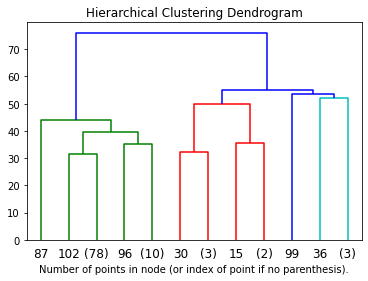

In [47]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


#iris = load_iris()
#X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Neighborhood 99 seems quite interesting. All algorithms return it in a single sample cluster.

In [48]:
table_cat.iloc[99,:]

Postal Code                                   M4Y
Borough                          Downtown Toronto
Neighborhood                 Church and Wellesley
Latitude                                  43.6659
Longitude                                -79.3832
                                     ...         
Hotel Bar                                       0
Middle Eastern Restaurant                       0
Bistro                                          0
Garden                                          0
Tea Room                                        0
Name: 99, Length: 279, dtype: object

This makes sense that the central downtown seems quite outstanding among the compared neighborhood. Lets head on!

<h3>Function for Automatic Clustering</h3>

Let us go ahead and define running these clustering models as function for later interactive use.

In [49]:
def clustering(Venue_Numbers, Total_Number, Mean_Distance, n_clusters, Report):
    """
    This function runs all clustering algorithms that we chose to cluster our neighborhoods.
    
    Variables:
        Venue_Numbers (String): 'Absolute' or 'Relative'. Defines if we divide venue numbers
            by total venue number before using the dataframe.
        Total_Number (Boolean): Defines if total venue number shall be used.
        Mean_Distance (Boolean): Defines if the mean distance shall be used.
        n_clusters (Integer): Defines the number of clusters to generate.
        Report (Boolean): Defines if a report shall be printed summarizing the total no. of 
            neighborhoods in a cluster and listing all contained clusters for each clustering
            algorithm.
    
    It returns:
    table_cat_clusters
    
    This is our old table_cat concatenated with the cluster labels of the different clustering
    algorithms.
    """

    #Let us introduce filter methods in order to be able to use/ignore the mean distance of locations,
    #the total number of avenues and also to be able to either use relative or absolute venue
    #numbers.
    if Venue_Numbers=='Absolute':
        table_clusters = table_cat.iloc[:,5:]
        if Total_Number==False:
            table_clusters.drop(columns='Number of venues')
        if Mean_Distance==False:
            table_clusters.drop(columns='Distance to others')
            
    else:
        table_clusters = pd.concat([table_cat.iloc[:,5:7], table_cat.iloc[:,7:].divide(table_cat.iloc[:,6], axis=0)], axis=1)
        table_clusters.fillna(value=0, inplace=True)
        if Total_Number==False:
            table_clusters.drop(columns='Number of venues')
        if Mean_Distance==False:
            table_clusters.drop(columns='Distance to others')
    
    #Now let us scale, fit and transform the resulting table for use in our ML algorithms.
    X = StandardScaler().fit_transform(table_clusters)
    
    #
    methods=[]

    #K-Means with k-means++ initialization
    method='K-Means (k-means++)'
    kmeans = KMeans(n_clusters, random_state=0, algorithm='auto', init='k-means++').fit(X)
    if(Report)==True:
        print('\nReport for {}:'.format(method))
    for label in set(kmeans.labels_):
        label_list =[]
        for index, g in enumerate(kmeans.labels_):
            if g==label:
                label_list.append(index)
        if(Report)==True:
            print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))

    table_cat_clusters = pd.concat([table_cat, pd.DataFrame(kmeans.labels_).rename(columns={0:method})], axis=1)
    methods.append(method)

    #K-Means with auto initialization
    method='K-Means (Auto)'
    kmeans = KMeans(n_clusters, random_state=0, algorithm='auto', init='random').fit(X)
    if(Report)==True:
        print('\nReport for {}:'.format(method))
    for label in set(kmeans.labels_):
        label_list =[]
        for index, g in enumerate(kmeans.labels_):
            if g==label:
                label_list.append(index)
        if(Report)==True:
            print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))

    table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(kmeans.labels_).rename(columns={0:method})], axis=1)
    methods.append(method)

    #K-Means with auto initialization and principal component analysis
    method='K-Means (PCA)'
    pca = decomposition.PCA(n_components=4)
    pca.fit(X)
    X = pca.transform(X)

    kmeans = KMeans(n_clusters, random_state=0, algorithm='auto').fit(X)
    if(Report)==True:
        print('\nReport for {}:'.format(method))
    for label in set(kmeans.labels_):
        label_list =[]
        for index, g in enumerate(kmeans.labels_):
            if g==label:
                label_list.append(index)
        if(Report)==True:
            print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))

    table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(kmeans.labels_).rename(columns={0:method})], axis=1)
    methods.append(method)

    #Agglomerative Clustering
    method='Agglomerative Clustering'
    X = StandardScaler().fit_transform(X)
    AC = AgglomerativeClustering(n_clusters).fit(X)
    if(Report)==True:
        print('\nReport for {}:'.format(method))
    for label in set(AC.labels_):
        label_list =[]
        for index, g in enumerate(AC.labels_):
            if g==label:
                label_list.append(index)
        if(Report)==True:
            print('The following {} neighborhoods belong to cluster {}: {}'.format(len(label_list), label, ', '.join(map(str, label_list))))

    table_cat_clusters = pd.concat([table_cat_clusters, pd.DataFrame(AC.labels_).rename(columns={0:method})], axis=1)
    methods.append(method)

    return table_cat_clusters


In [50]:
help(clustering)

Help on function clustering in module __main__:

clustering(Venue_Numbers, Total_Number, Mean_Distance, n_clusters, Report)
    This function runs all clustering algorithms that we chose to cluster our neighborhoods.
    
    Variables:
        Venue_Numbers (String): 'Absolute' or 'Relative'. Defines if we divide venue numbers
            by total venue number before using the dataframe.
        Total_Number (Boolean): Defines if total venue number shall be used.
        Mean_Distance (Boolean): Defines if the mean distance shall be used.
        n_clusters (Integer): Defines the number of clusters to generate.
        Report (Boolean): Defines if a report shall be printed summarizing the total no. of 
            neighborhoods in a cluster and listing all contained clusters for each clustering
            algorithm.
    
    It returns:
    table_cat_clusters
    
    This is our old table_cat concatenated with the cluster labels of the different clustering
    algorithms.



Good, that should help others to use this function as well.

<h3>Result Visualizaton</h3>

We will now plot a map of Torronto and label our neighborhoods.

In [51]:
g = geocoder.osm('Toronto, Ontario'.format(postal_code))
lat_lng_coords = g.latlng


latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]
print('The geograpical coordinates of Torronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Torronto are 43.6534817, -79.3839347.


In [52]:

# create map of Torronto using latitude and longitude values
map_torronto = folium.Map(location=[latitude, longitude], zoom_start=10)
i=0
# add markers to map
for lat, lng, borough, neighborhood in zip(table_cat['Latitude'], table_cat['Longitude'], table_cat['Borough'], table_cat['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_torronto)  
    i+=1
print('The number of inserted neighborhoods is', i, '.')
map_torronto

The number of inserted neighborhoods is 103 .


Now we will plot a more useful map! Let us make an interactive map where we can look at the different clustering algorithms (together with the number of clusters) and also chose if we want the total number and mean distance of venues included. Furthermore, we want to be able to chose using either relative or absolute venue numbers. This is an important difference depending on what we want to achieve with our analysis in later parts of this project. Relative numbers give an insight into the structure of existing venues, but absolute numbers are also important for making a call on where starting a new business might be important. A neighborhood lacking a Chinese restaurant but being filled with dozens of others is not a smart place to open one. Additional funcationality for getting a zoom into the most interesting region and for generating a written report were added.

In [53]:
import folium.plugins
from folium.features import *

class DivIcon(MacroElement):
    def __init__(self, html='', size=(30,30), anchor=(0,0), style=''):
        """TODO : docstring here"""
        super(DivIcon, self).__init__()
        self._name = 'DivIcon'
        self.size = size
        self.anchor = anchor
        self.html = html
        self.style = style

        self._template = Template(u"""
            {% macro header(this, kwargs) %}
              <style>
                .{{this.get_name()}} {
                    {{this.style}}
                    }
              </style>
            {% endmacro %}
            {% macro script(this, kwargs) %}
                var {{this.get_name()}} = L.divIcon({
                    className: '{{this.get_name()}}',
                    iconSize: [{{ this.size[0] }},{{ this.size[1] }}],
                    iconAnchor: [{{ this.anchor[0] }},{{ this.anchor[1] }}],
                    html : "{{this.html}}",
                    });
                {{this._parent.get_name()}}.setIcon({{this.get_name()}});
            {% endmacro %}
            """)

In [54]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from ipywidgets import *

def Draw_Map(Venue_Numbers, Total_Number, Mean_Distance, Method, n_clusters, Zoom_City_Centre, Show_Venues, Report):
    
    n_clusters=int(n_clusters)
    table_cat_clusters = clustering(Venue_Numbers, Total_Number, Mean_Distance, n_clusters, Report)
    
    # create map
    if Zoom_City_Centre==True:
        initial_zoom_int = 14
        marker_radius = 9
    else:
        initial_zoom_int = 10
        marker_radius = 4
        
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=initial_zoom_int)

    #kclusters=table_cat_clusters[method].max()+1
    # set color scheme for the clusters
    x = np.arange(n_clusters)
    ys = [i + x + (i*x)**2 for i in range(n_clusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster, venue_count in zip(table_cat_clusters['Latitude'], table_cat_clusters['Longitude'], table_cat_clusters['Neighborhood'], table_cat_clusters[Method], table_cat_clusters['Number of venues']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        
        #Let us define the index for our marker color by the appearance rate for easier visual comparison
        for i in range(n_clusters):
            if cluster==table_cat_clusters[Method].value_counts().index[i]:
                marker_color = i
            else:
                None
        
        #Create circle markers with different colors for each cluster.
        folium.CircleMarker(
            [lat, lon],
            radius=marker_radius,
            popup=label,
            color=rainbow[marker_color],
            fill=True,
            fill_color=rainbow[marker_color],
            fill_opacity=0.7).add_to(map_clusters)
        
        #Add text markers denouncing the total number of venues in the neighborhood.
        if Show_Venues==True:
            folium.map.Marker(
                [lat, lon],
                icon=DivIcon(
                size=(150,36),
                anchor=(157,8),
                html=str(venue_count),
                style="""
                    font-size:12px;
                    background-color: transparent;
                    border-color: transparent;
                    text-align: right;
                    """
            )
            ).add_to(map_clusters)
        
    return map_clusters

interact(Draw_Map, Venue_Numbers=['Absolute', 'Relative'],
         Total_Number=True,
         Mean_Distance=True,
         Method=methods,
         n_clusters=widgets.IntSlider(min=1, max=10, step=1, value=5, continuous_update=False),
         Zoom_City_Centre=False,
         Show_Venues=False,
         Report=False
        )

interactive(children=(Dropdown(description='Venue_Numbers', options=('Absolute', 'Relative'), value='Absolute'…

<function __main__.Draw_Map(Venue_Numbers, Total_Number, Mean_Distance, Method, n_clusters, Zoom_City_Centre, Show_Venues, Report)>

Very cool!

We now have an interactive map and can look at different clustering algorithms and at different data treatment ways all in one! It seems that mainly the dense areas get grouped in different clusters than areas with less recorded venues. We will likely want to focus on the 1 or 2 clusters containing the most neighborhoods which are rather sparsely equipped with venues currently to minimize competition.

As interactive widgets will not show on Github or on NBViewer, please find a screenshot of above map here. Feel free to download the notebook and test it yourself!

<img src="files/figures/interactive_map.png">

One thing that this analysis makes very clear is that we will definitely need to use relative venue counts in order to include some of the neighborhoods outside of the very center into our analysis.

Switching to relative will lead to very different clusters:

<img src="files/figures/interactive_map2.png">